In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['STHeiti']
mpl.rcParams['font.serif'] = ['STHeiti']
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['STHeiti', 'STHeiti']})
# Set Default Encoding
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

 # 概述
 前面分析了基金的收益等信息，这一篇分析基金经理和公司。主要思路为挑选收益排名靠前且稳定的经理和公司。
 # 数据
 ## 数据读取
 ▍读取基金涨跌幅数据

In [2]:
rate = pd.read_csv('./data/mixed_funds_rate.csv',dtype={'code':str})
rate['date'] = pd.to_datetime(rate['date'])
rate.set_index('date',inplace=True)
rate.sort_index(inplace=True)

▍读取基金信息数据

In [3]:
inf = pd.read_csv('./data/mixed_funds.csv',dtype={'code':str})
inf.set_index('code',inplace=True)

## 数据预处理
▍将涨跌幅数据转换为每年收益  
考虑基金经理有可能更换，而且近几年才有大量基金，选取 2015 年以后的数据，忽略基金经理的更换。计算 2015-2017 年每只基金的每年收益，只计算每年交易日数在 200 以上的基金。

In [4]:
years = range(2015,2018)
rate_per_year = pd.DataFrame(index=rate.columns)
for year in years:
    df = rate[str(year)]
    df =df[df.columns[df.notnull().sum()>200]]
    rate_per_year[str(year)] = (df/100+1).cumprod().ix[-1]-1
# drop NAN
rate_per_year.dropna(inplace=True)

▍将数据整合为一张表并加入一列平均值和标准差

In [5]:
df = pd.merge(rate_per_year,inf,how='left',right_index=True,left_index=True)
df.insert(3,'mean',rate_per_year.mean(axis=1))
df.insert(3,'std',rate_per_year.std(axis=1))
df.head()

,2015,2016,2017,std,mean,name,type,manager,company
000057,0.315431,-0.283896,0.200587,0.318095,0.077374,中银消费主题混合,混合型,钱亚风云,中银基金
000061,0.318863,-0.144086,-0.074713,0.249679,0.033355,华夏盛世混合,混合型,代瑞亮,华夏基金
000063,1.552711,-0.290389,0.074095,0.976061,0.445472,长盛电子信息主题灵活配置混合,混合型,赵宏宇,长盛基金
000083,0.818368,-0.115797,0.441166,0.469956,0.381246,汇添富消费行业混合,混合型,胡昕炜,汇添富基金
000117,0.735252,-0.131474,0.189482,0.438195,0.264420,广发轮动配置混合,混合型,吴兴武,广发基金


## 数据分析
### 经理分析
▍查看一下排名靠前的经理   
根据每年收益的平均值排名。

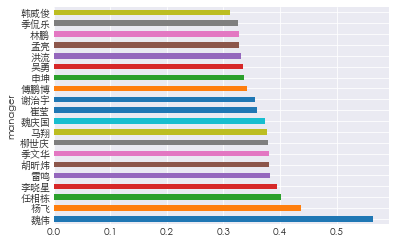

In [6]:
df.groupby('manager')['mean'].mean().sort_values(ascending=False)[:20].plot(kind='barh')
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_2.png",dpi=300)

▍查看一下我们的第一名管理的基金，确认没有错误

In [8]:
df[df['manager']==u"魏伟"]

,2015,2016,2017,std,mean,name,type,manager,company
100056,1.629173,-0.286903,0.348671,0.97596,0.563647,富国低碳环保混合,混合型,魏伟,富国基金


第一名管理的基金在 2015 年上涨了 1.6 倍，然而在 2016 年还赔了，并不稳定，平均值没有反应基金的稳定性。从标准差方面考虑下。  
▍查看所有基金的标准差分布

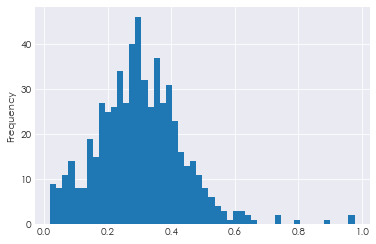

In [7]:
rate_per_year.std(axis=1).plot(kind='hist',bins=50)
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_4.png",dpi=300)

▍挑选标准差在 0.6 以下的基金排名

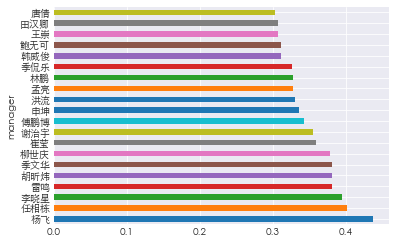

In [8]:
df[df['std']<0.6].groupby('manager')['mean'].mean().sort_values(ascending=False)[:20].plot(kind='barh')
#df.groupby('manager')['mean'].mean()
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_5.png",dpi=300)

In [10]:
df[df['manager']==u"杨飞"]

,2015,2016,2017,std,mean,name,type,manager,company
020003,0.817584,0.027959,0.331815,0.398290,0.392453,国泰金龙行业精选,混合型,杨飞,国泰基金
160211,0.884976,0.005177,0.396917,0.440777,0.429023,国泰中小盘成长混合(LOF,混合型,杨飞,国泰基金
160212,1.043188,0.014862,0.407310,0.518943,0.488453,国泰估值优势混合(LOF),混合型,杨飞,国泰基金


从魏伟和杨飞管理的基金中看出，在 2015 年，基金基本都大涨，然后进入 2016 年回调器，基金上涨较少甚至下跌，现在 2017 年势头良好。

▍查看一下这四只基金的净值变化

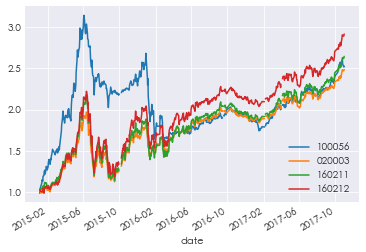

In [9]:
(rate['2015':'2017'][['100056','020003','160211','160212']]/100+1).cumprod().plot()
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_7.png",dpi=300)

短期来看，在股市牛市中，100056 的选股能力更强，长期来看的话，四只基金的表现差不多。或许标准差不应该纳入评价。但可能是个例分析的偏差。   
### 公司分析
采用上述同样的方法。   
▍查看公司

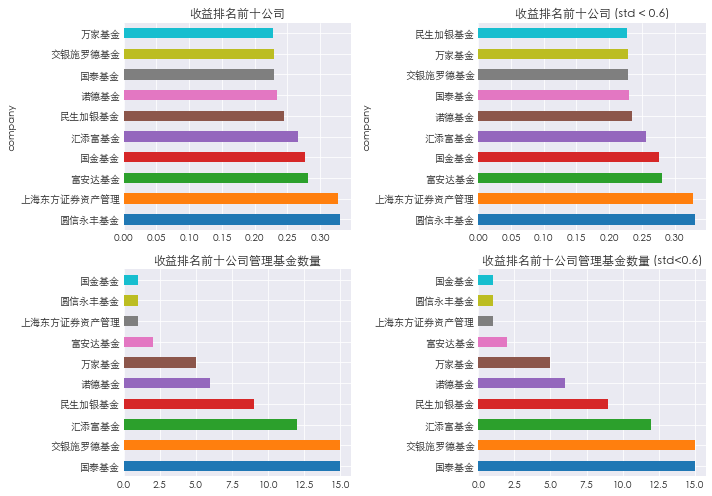

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,7))
#
df.groupby('company')['mean'].mean().sort_values(ascending=False)[:10].plot(kind='barh',ax=axes[0][0])
axes[0,0].set_title(u"收益排名前十公司")
#
df[df['std']<0.6].groupby('company')['mean'].mean().sort_values(ascending=False)[:10].plot(kind='barh',ax=axes[0][1])
axes[0,1].set_title(u"收益排名前十公司 (std < 0.6)")
#
top10 = df.groupby('company')['mean'].mean().sort_values(ascending=False)[:10].index
df[df['company'].isin(top10)]['company'].value_counts().plot(kind='barh',ax=axes[1,0])
axes[1,0].set_title(u"收益排名前十公司管理基金数量")
#
top10 = df[df['std']<0.6].groupby('company')['mean'].mean().sort_values(ascending=False)[:10].index
df[df['company'].isin(top10)]['company'].value_counts().plot(kind='barh',ax=axes[1,1])
axes[1,1].set_title(u"收益排名前十公司管理基金数量 (std<0.6)")
plt.tight_layout()
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_8.png",dpi=300)

# 基金买卖
经过上面的分析，挑选数量和质量都比较过得过去的基金公司国泰基金，同时挑选的经理为杨飞。选取收益最高的 160212 分析什么时候买入卖出。   
## 星期几？   
分析星期几买入或卖出较好。   
▍选取数据并按星期聚类

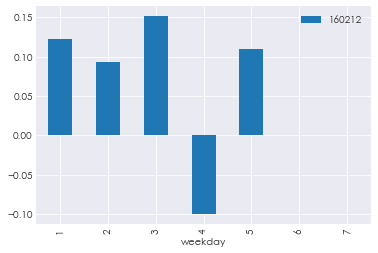

In [13]:
fund  = rate['160212'].dropna().to_frame()
fund['weekday'] = fund.index.dayofweek+1
fund.groupby('weekday').mean().plot(kind='bar')
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_9.png",dpi=300)

很明显，该基金在星期四的时候，下跌的情况较多，建议可以星期四买入，卖出的话是星期三比较好，稍高一点。加入我每周四买入，每周三卖出，收益会比不动高吗？

▍收益计算
设置每次交易的手续费为 0.1%，每周四买入，每周三卖出。

In [14]:
fund_nav = (fund['160212']/100.+1).cumprod().to_frame()
fund_nav['weekday'] = fund_nav.index.dayofweek + 1
#
principal = 1
sale = True
buy = False
fee = 0.1/100
for day in range(len(fund_nav)):
    if sale & (fund_nav['weekday'][day]==4):
        share = principal*(1-fee)/fund_nav['160212'][day]
        sale = False
        buy = True
    if buy & (fund_nav['weekday'][day]==3):
        principal = share*fund_nav['160212'][day]*(1-fee)
        sale = True
        buy = False
print u"是时候展示操作的收益： %f"  % principal
print u"不操作收益： %f"  % fund_nav['160212'][-1]

是时候展示操作的收益： 1.866846
不操作收益： 3.109438


* 是时候展示操作的收益： 1.866846
* 不操作收益： 3.109438

卵用都没用，不是说周四买入周三卖出是最好的吗！！！肯定是每次操作产生的手续费引起的。重新设置为费用为 0 再来看一次。
* 是时候展示操作的收益 (无手续费)： 3.898604
* 不操作收益： 3.109438

还是有比较明显的差别，基金交易的手续费是吸血鬼。
        

## 第几天？

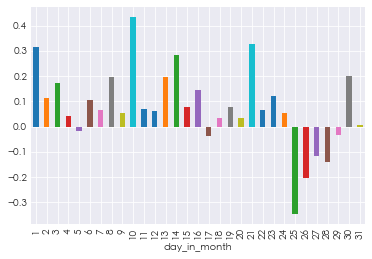

In [15]:
fund['day_in_month'] = fund.index.day
fund.groupby('day_in_month')['160212'].mean().plot(kind='bar')
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_10.png",dpi=300)

## 第几月？

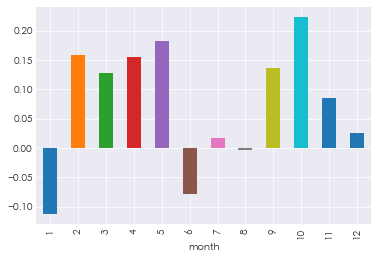

In [16]:
fund['month'] = fund.index.month
fund.groupby('month')['160212'].mean().plot(kind='bar')
plt.savefig("/Users/lli/Documents/GitHub/zhihu/source/img/funds/3_11.png",dpi=300)